

- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

plt.style.use('seaborn')

In [2]:
# getting the data
file = "../input/entity-annotated-corpus/ner_dataset.csv"
data = pd.read_csv(file, encoding = "latin1")

# drop the POS column because we dont need it
data = data.drop('POS', 1)

In [3]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


In [4]:
# Fill na
data = data.fillna(method = 'ffill')

In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

print(f"Total number of unique words in dataset: {num_words}")

Total number of unique words in dataset: 35179


In [6]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: I-nat, B-art, B-eve, B-per, O, B-nat, B-gpe, I-art, I-org, I-per, B-tim, B-geo, B-org, I-eve, I-geo, I-gpe, I-tim
Total Number of tags 17


In [7]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = Get_sentence(data)
sentence = getter.sentences
sentence[10]

[('In', 'O'),
 ('Beirut', 'B-geo'),
 (',', 'O'),
 ('a', 'O'),
 ('string', 'O'),
 ('of', 'O'),
 ('officials', 'O'),
 ('voiced', 'O'),
 ('their', 'O'),
 ('anger', 'O'),
 (',', 'O'),
 ('while', 'O'),
 ('at', 'O'),
 ('the', 'O'),
 ('United', 'B-org'),
 ('Nations', 'I-org'),
 ('summit', 'O'),
 ('in', 'O'),
 ('New', 'B-geo'),
 ('York', 'I-geo'),
 (',', 'O'),
 ('Prime', 'B-per'),
 ('Minister', 'O'),
 ('Fouad', 'B-per'),
 ('Siniora', 'I-per'),
 ('said', 'O'),
 ('the', 'O'),
 ('Lebanese', 'B-gpe'),
 ('people', 'O'),
 ('are', 'O'),
 ('resolute', 'O'),
 ('in', 'O'),
 ('preventing', 'O'),
 ('such', 'O'),
 ('attempts', 'O'),
 ('from', 'O'),
 ('destroying', 'O'),
 ('their', 'O'),
 ('spirit', 'O'),
 ('.', 'O')]

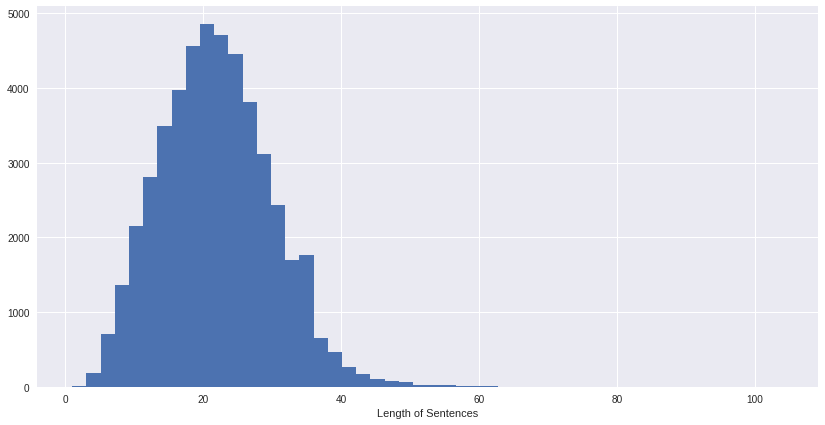

In [9]:
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

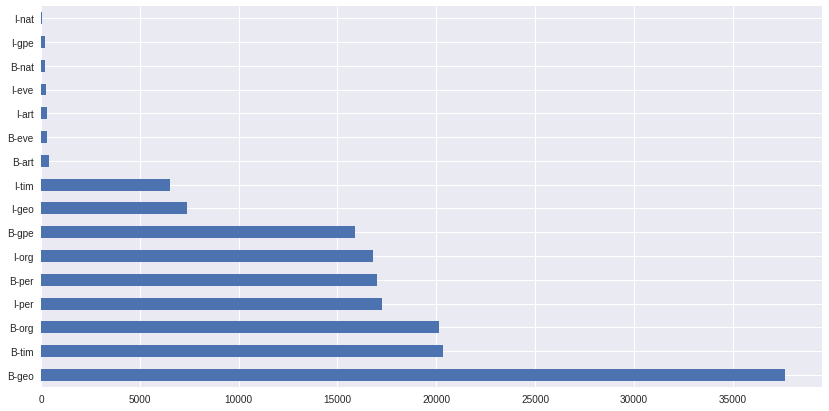

In [10]:
plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

In [11]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [12]:
tag_idx

{'I-nat': 0,
 'B-art': 1,
 'B-eve': 2,
 'B-per': 3,
 'O': 4,
 'B-nat': 5,
 'B-gpe': 6,
 'I-art': 7,
 'I-org': 8,
 'I-per': 9,
 'B-tim': 10,
 'B-geo': 11,
 'B-org': 12,
 'I-eve': 13,
 'I-geo': 14,
 'I-gpe': 15,
 'I-tim': 16}

In [13]:
max_len = 50
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words - 1)

y = [[tag_idx[w[1]] for w in s] for s in sentence]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag_idx['O'])
y = [to_categorical(i, num_classes = num_tags) for i in  y]

In [14]:
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size = 0.1, random_state = 1)

In [15]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100,return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


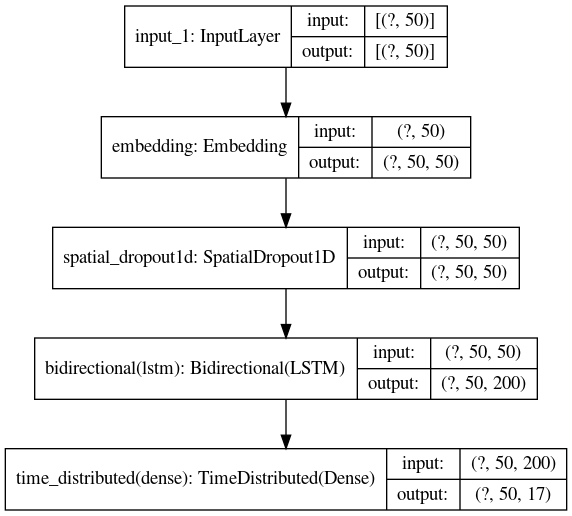

In [16]:
plot_model(model, show_shapes = True)

In [17]:
model.fit(x_train, np.array(y_train), batch_size = 64, verbose = 1, epochs = 3, validation_split = 0.2)

Epoch 1/3
540/540 [==============================] - 67s 124ms/step - loss: 0.2671 - accuracy: 0.9432 - val_loss: 0.1182 - val_accuracy: 0.9665
Epoch 2/3
540/540 [==============================] - 67s 124ms/step - loss: 0.0788 - accuracy: 0.9782 - val_loss: 0.0596 - val_accuracy: 0.9824
Epoch 3/3
540/540 [==============================] - 67s 124ms/step - loss: 0.0479 - accuracy: 0.9860 - val_loss: 0.0515 - val_accuracy: 0.9844


In [18]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 2s 13ms/step - loss: 0.0537 - accuracy: 0.9841


[0.053686127066612244, 0.9840950965881348]

In [19]:
rand_sent = np.random.randint(0, x_test.shape[0]) # get a random sentense
p = model.predict(np.array([x_test[rand_sent]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[rand_sent] # get actual tags for random sentense

print("{:20}{:20}\t{}\n".format("Word", "True", "Pred"))
print("-" * 55)

for (w, t, pred) in zip(x_test[rand_sent], y_true, p[0]):
    print("{:20}{:20}\t{}".format(words[w - 1], tags[t], tags[pred]))

Word                True                	Pred

-------------------------------------------------------
Iran                B-geo               	B-geo
's                  O                   	O
influential         O                   	O
former              O                   	O
president           O                   	O
,                   O                   	O
Akbar               B-org               	B-per
Hashemi             I-org               	I-per
Rafsanjani          I-org               	I-per
,                   O                   	O
has                 O                   	O
praised             O                   	O
the                 O                   	O
late                O                   	O
Pope                O                   	O
John                B-per               	B-per
Paul                I-per               	I-per
II                  I-per               	I-per
as                  O                   	O
a                   O                   	O
man      

In [20]:
def create_test_input_from_text(text):
    word_list = text.split(" ")
    x_new = []
    for word in word_list:
        x_new.append(word_idx[word])
        
    p = model.predict(np.array([x_new]))
    p = np.argmax(p, axis = -1)
    print("{:20}\t{}\n".format("Word", "Prediction"))
    print("-" * 35)

    for (w, pred) in zip(range(len(x_new)), p[0]):
        print("{:20}\t{}".format(word_list[w], tags[pred]))

In [21]:

test_inputs = "the weather in London is very hot"
create_test_input_from_text(test_inputs)

Word                	Prediction

-----------------------------------
the                 	O
weather             	O
in                  	O
London              	B-geo
is                  	O
very                	O
hot                 	O


In [22]:

test_inputs = "my friend Mohammed is travelling to Oman"
create_test_input_from_text(test_inputs)

Word                	Prediction

-----------------------------------
my                  	O
friend              	O
Mohammed            	B-per
is                  	O
travelling          	B-geo
to                  	O
Oman                	B-geo
